# Unsupervised learning - clustering 

Cluster particle signatures into 3+ catagories. This should also be based maximum 10 variables from the Electron Variable List. In this case, there is no target variable, as this is unsupervised learning. We evaluate algorithm performance by ability of your catagories to fit into electron/non-electron classification. 

We start by opening the files and loading them into a Numpy array

In [1]:
import h5py
import pandas
from copy import deepcopy
import numpy as np
from sklearn.preprocessing import RobustScaler, QuantileTransformer
from sklearn.ensemble import GradientBoostingClassifier
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import KernelPCA




import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def load_data(name):
    with h5py.File(f'{name}.h5', 'r') as f:
        return pandas.DataFrame(f[name][:])

train = load_data('train')
test  = load_data('test')

In [3]:
## temporarily use a fraction of the data to speed everything up
#train=train.sample(frac = 0.7)

Then we can verify the shape

In [4]:
print (f'Shape of training data set: {train.shape}')
print (f'Shape of test data set: {test.shape}')

Shape of training data set: (162500, 166)
Shape of test data set: (160651, 164)


As expected, the test set contains 2 columns less: `Truth` and `p_truth_E`.
    
Then we copy the variable list from the course website <https://www.nbi.dk/~petersen/Teaching/ML2020/SmallProject/VariableList.html>

In [5]:
all_variables = ['actualInteractionsPerCrossing', 'averageInteractionsPerCrossing', 'correctedActualMu', 'correctedAverageMu', 'correctedScaledActualMu', 'correctedScaledAverageMu', 'NvtxReco', 'p_nTracks', 'p_pt_track', 'p_eta', 'p_phi', 'p_charge', 'p_qOverP', 'p_z0', 'p_d0', 'p_sigmad0', 'p_d0Sig', 'p_EptRatio', 'p_dPOverP', 'p_z0theta', 'p_etaCluster', 'p_phiCluster', 'p_eCluster', 'p_rawEtaCluster', 'p_rawPhiCluster', 'p_rawECluster', 'p_eClusterLr0', 'p_eClusterLr1', 'p_eClusterLr2', 'p_eClusterLr3', 'p_etaClusterLr1', 'p_etaClusterLr2', 'p_phiClusterLr2', 'p_eAccCluster', 'p_f0Cluster', 'p_etaCalo', 'p_phiCalo', 'p_eTileGap3Cluster', 'p_cellIndexCluster', 'p_phiModCalo', 'p_etaModCalo', 'p_dPhiTH3', 'p_R12', 'p_fTG3', 'p_weta2', 'p_Reta', 'p_Rphi', 'p_Eratio', 'p_f1', 'p_f3', 'p_Rhad', 'p_Rhad1', 'p_deltaEta1', 'p_deltaPhiRescaled2', 'p_TRTPID', 'p_TRTTrackOccupancy', 'p_numberOfInnermostPixelHits', 'p_numberOfPixelHits', 'p_numberOfSCTHits', 'p_numberOfTRTHits', 'p_numberOfTRTXenonHits', 'p_chi2', 'p_ndof', 'p_SharedMuonTrack', 'p_E7x7_Lr2', 'p_E7x7_Lr3', 'p_E_Lr0_HiG', 'p_E_Lr0_LowG', 'p_E_Lr0_MedG', 'p_E_Lr1_HiG', 'p_E_Lr1_LowG', 'p_E_Lr1_MedG', 'p_E_Lr2_HiG', 'p_E_Lr2_LowG', 'p_E_Lr2_MedG', 'p_E_Lr3_HiG', 'p_E_Lr3_LowG', 'p_E_Lr3_MedG', 'p_ambiguityType', 'p_asy1', 'p_author', 'p_barys1', 'p_core57cellsEnergyCorrection', 'p_deltaEta0', 'p_deltaEta2', 'p_deltaEta3', 'p_deltaPhi0', 'p_deltaPhi1', 'p_deltaPhi2', 'p_deltaPhi3', 'p_deltaPhiFromLastMeasurement', 'p_deltaPhiRescaled0', 'p_deltaPhiRescaled1', 'p_deltaPhiRescaled3', 'p_e1152', 'p_e132', 'p_e235', 'p_e255', 'p_e2ts1', 'p_ecore', 'p_emins1', 'p_etconeCorrBitset', 'p_ethad', 'p_ethad1', 'p_f1core', 'p_f3core', 'p_maxEcell_energy', 'p_maxEcell_gain', 'p_maxEcell_time', 'p_maxEcell_x', 'p_maxEcell_y', 'p_maxEcell_z', 'p_nCells_Lr0_HiG', 'p_nCells_Lr0_LowG', 'p_nCells_Lr0_MedG', 'p_nCells_Lr1_HiG', 'p_nCells_Lr1_LowG', 'p_nCells_Lr1_MedG', 'p_nCells_Lr2_HiG', 'p_nCells_Lr2_LowG', 'p_nCells_Lr2_MedG', 'p_nCells_Lr3_HiG', 'p_nCells_Lr3_LowG', 'p_nCells_Lr3_MedG', 'p_pos', 'p_pos7', 'p_poscs1', 'p_poscs2', 'p_ptconeCorrBitset', 'p_ptconecoreTrackPtrCorrection', 'p_r33over37allcalo', 'p_topoetconeCorrBitset', 'p_topoetconecoreConeEnergyCorrection', 'p_topoetconecoreConeSCEnergyCorrection', 'p_weta1', 'p_widths1', 'p_widths2', 'p_wtots1', 'p_e233', 'p_e237', 'p_e277', 'p_e2tsts1', 'p_ehad1', 'p_emaxs1', 'p_fracs1', 'p_DeltaE', 'p_E3x5_Lr0', 'p_E3x5_Lr1', 'p_E3x5_Lr2', 'p_E3x5_Lr3', 'p_E5x7_Lr0', 'p_E5x7_Lr1', 'p_E5x7_Lr2', 'p_E5x7_Lr3', 'p_E7x11_Lr0', 'p_E7x11_Lr1', 'p_E7x11_Lr2', 'p_E7x11_Lr3', 'p_E7x7_Lr0', 'p_E7x7_Lr1' ]

Finally, we divide the training data into data (`X`) and targets (`y`)

Only use the entries which we know are true electrons for training.


In [6]:
#train = train.loc[train['Truth']==1]
X = train[all_variables]
X_test = test[all_variables]


y = train['Truth']

print (f'Shape of X: {X.shape}')
print (f'Shape of y: {y.shape}')

Shape of X: (162500, 160)
Shape of y: (162500,)


In [7]:
X.head(2)

,actualInteractionsPerCrossing,averageInteractionsPerCrossing,correctedActualMu,correctedAverageMu,correctedScaledActualMu,correctedScaledAverageMu,NvtxReco,p_nTracks,p_pt_track,p_eta,...,p_E5x7_Lr0,p_E5x7_Lr1,p_E5x7_Lr2,p_E5x7_Lr3,p_E7x11_Lr0,p_E7x11_Lr1,p_E7x11_Lr2,p_E7x11_Lr3,p_E7x7_Lr0,p_E7x7_Lr1
0,26.5,26.5,26.5,26.5,26.5,26.5,18,3,42011.792969,1.834715,...,215.588013,43402.332031,74045.820312,337.980713,273.708801,43091.683594,74447.539062,470.177124,273.708801,43091.683594
1,35.5,35.5,35.5,35.5,35.5,35.5,23,4,39722.859375,-1.592156,...,10502.792969,36774.925781,58228.847656,412.321869,10861.282227,37433.324219,61805.964844,460.203613,10861.282227,37433.324219


## Preprocessing

### Check null values

In [8]:
train.isnull().sum()

eventNumber                       0
runNumber                         0
actualInteractionsPerCrossing     0
averageInteractionsPerCrossing    0
correctedActualMu                 0
                                 ..
p_E7x11_Lr2                       0
p_E7x11_Lr3                       0
p_E7x7_Lr0                        0
p_E7x7_Lr1                        0
index                             0
Length: 166, dtype: int64

No nulls
### Scale the data

In [11]:
transformed_X = deepcopy(X) 
transformed_X_test = deepcopy(X_test)
# This loop transforms every variable _independently_ 
for variable in X.columns: 
    scaler = QuantileTransformer().fit(np.array(transformed_X[variable]).reshape(-1,1))
    transformed_X[variable] = scaler.transform(np.array(transformed_X[variable]).reshape(-1,1))
    transformed_X_test[variable] = scaler.transform(np.array(transformed_X_test[variable]).reshape(-1,1))

### Select k Best features  
Use the electron/not electron truth field to choose the 10 best features

In [12]:
from sklearn.feature_selection import SelectKBest, f_regression, f_classif

In [13]:
# X_10 = SelectKBest(score_func=f_classif, k=10).fit_transform(transformed_X,y)
# X_10.shape

In [14]:
# Create and fit selector
selector = SelectKBest(score_func=f_classif, k=10)
X_10 = selector.fit_transform(transformed_X, y)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
features_df_new = train.iloc[:,cols]
features_df_new.columns

/opt/conda/envs/python3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 67  73  76 101 113 119 122 128 131 136] are constant.
  UserWarning)
/opt/conda/envs/python3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Index(['p_R12', 'p_fTG3', 'p_Eratio', 'p_f1', 'p_ndof', 'p_e255', 'p_e2ts1',
       'p_pos7', 'p_wtots1', 'p_E5x7_Lr2'],
      dtype='object')

In [15]:
transformed_X_test_10 = selector.transform(transformed_X_test)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_10, y, test_size=0.25, 
                                                    shuffle=True, random_state=42)

# K-Means clustering

100%|██████████| 8/8 [00:49<00:00,  6.20s/it]


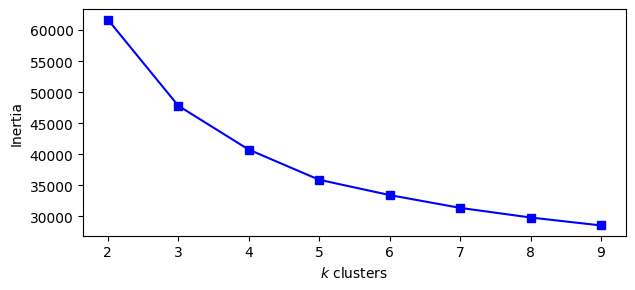

In [17]:
from sklearn.cluster import KMeans

# loop over several k values and record inertias
ks = np.arange(2, 10)
inertias = []
for k in tqdm(ks):
    kmeans = KMeans(n_clusters=k, init='k-means++', 
                    n_init=10, random_state=42)
    kmeans.fit(X_train)
    inertias.append(kmeans.inertia_)

fig, ax = plt.subplots(1, dpi=100, figsize=(7,3), 
                       subplot_kw={'xlabel': '$k$ clusters', 
                                   'ylabel': 'Inertia'})
plt.plot(ks, inertias, 'bs-')
#plt.plot(3, inertias[1], 'rs')
plt.show()

In [18]:
# from sklearn.metrics import silhouette_score

# ks = np.arange(2, 10)
# scores = []
# for k in tqdm(ks):
#     kmeans = KMeans(n_clusters=k, init='k-means++', 
#                     n_init=10, random_state=42)
#     kmeans.fit(X_10)
#     scores.append(silhouette_score(X_10, kmeans.labels_))

# fig, ax = plt.subplots(1, dpi=100, figsize=(7,3), 
#                        subplot_kw={'xlabel': '$k$ clusters', 
#                                    'ylabel': 'Silhouette Score'})
# plt.plot(ks, scores, 'bs-')
# #plt.plot(3, scores[1], 'rs')
# plt.show()

In [20]:
kmeans = KMeans(n_clusters=3, init='k-means++', 
                n_init=10, random_state=42)
kmeans.fit(X_train)
y_pred = kmeans.predict(X_val)

test_score = accuracy_score(y_val, y_pred)
print(f"Test score: {test_score:.3f}")

Test score: 0.544


In [21]:
for num_clus in tqdm(range(2,6)):
    kmeans = KMeans(n_clusters=num_clus, init='k-means++', 
                n_init=10, random_state=42)
    kmeans.fit(X_train)
    y_pred = kmeans.predict(X_val)

    test_score = accuracy_score(y_val, y_pred)
    print(f"Test score: {test_score:.3f}")

 25%|██▌       | 1/4 [00:01<00:04,  1.56s/it]

Test score: 0.225


 50%|█████     | 2/4 [00:03<00:03,  1.67s/it]

Test score: 0.544


 75%|███████▌  | 3/4 [00:07<00:02,  2.23s/it]

Test score: 0.042


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]

Test score: 0.204


### With UMAP

100%|██████████| 8/8 [00:25<00:00,  3.21s/it]


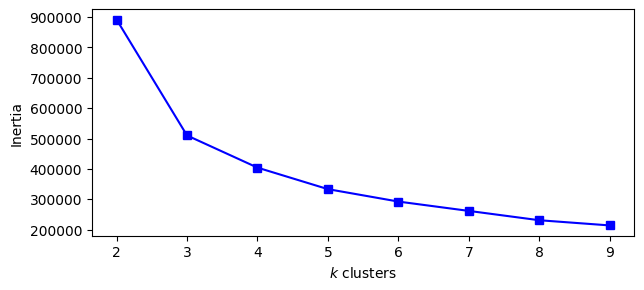

In [28]:
# loop over several k values and record inertias
ks = np.arange(2, 10)
inertias = []
for k in tqdm(ks):
    kmeans = KMeans(n_clusters=k, init='k-means++', 
                    n_init=10, random_state=42)
    kmeans.fit(X_train_umap)
    inertias.append(kmeans.inertia_)

fig, ax = plt.subplots(1, dpi=100, figsize=(7,3), 
                       subplot_kw={'xlabel': '$k$ clusters', 
                                   'ylabel': 'Inertia'})
plt.plot(ks, inertias, 'bs-')
#plt.plot(3, inertias[1], 'rs')
plt.show()

In [87]:
kmeans = KMeans(n_clusters=4, init='k-means++', 
                n_init=10, random_state=42)
kmeans.fit(X_train_umap6)
y_pred_kmeans_umap = kmeans.predict(X_val_umap6)

test_score = accuracy_score(y_val, y_pred_kmeans_umap)
print(f"Test score: {test_score:.3f}")

Test score: 0.518


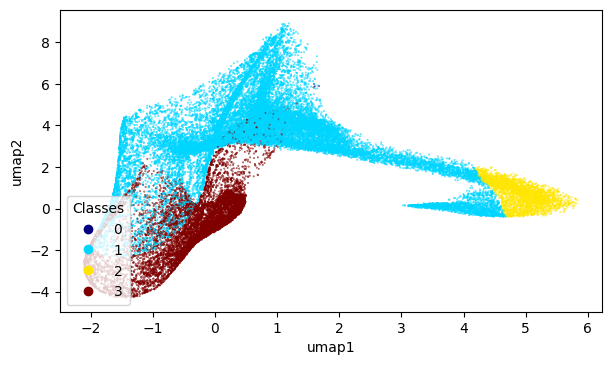

In [88]:
fig, ax = plt.subplots(1, figsize=(7,4), dpi=100,
                       subplot_kw={'xlabel': 'umap1', 
                                   'ylabel': 'umap2'})
scatter=plt.scatter(X_val_umap6[:, 0], X_val_umap6[:, 1],
            c=y_pred_kmeans_umap, s=0.1, cmap='jet');
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")

(array([4.0000e+00, 0.0000e+00, 0.0000e+00, 2.7457e+04, 0.0000e+00,
        0.0000e+00, 2.7840e+03, 0.0000e+00, 0.0000e+00, 1.0380e+04]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

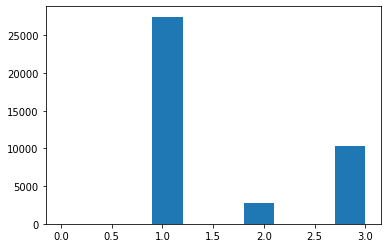

In [89]:
plt.hist(y_pred_kmeans_umap)

## UMAP

In [22]:
#!pip install umap-learn

     |████████████████████████████████| 81kB 4.8MB/s eta 0:00:011
     |████████████████████████████████| 3.4MB 8.5MB/s eta 0:00:01
     |████████████████████████████████| 1.2MB 42.5MB/s eta 0:00:01
     |████████████████████████████████| 25.3MB 335kB/s  eta 0:00:01B/s eta 0:00:011MB 36.4MB/s eta 0:00:01            | 8.9MB 36.4MB/s eta 0:00:01a 0:00:01    |████████████████▌               | 13.0MB 36.4MB/s eta 0:00:01eta 0:00:01   | 21.6MB 36.4MB/s eta 0:00:01
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=4c4c47c3491d96da3b7a65a7b3671195d9794455e6e95e306f6fa60443a95736
  Stored in directory: /home/jovyan/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51349 sha256=70014557a52bb0fea1fc3a2ea00d9f39bea9f8e17ec63d1e543f09d1a34a1473
  Stored in directory: /home/jovyan/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b5

In [23]:
import umap.umap_ as umap

### Standard umap parameters

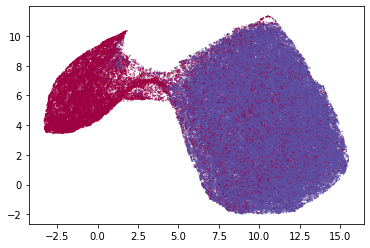

In [24]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(X_train.data)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], s=0.1, cmap='Spectral', c=y_train);

### UMAP recommended params for clustering

In [25]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=4,
    random_state=42,
    verbose=1
)

In [54]:
X_train_umap = clusterable_embedding.fit_transform(X_train)
#X_val_umap = clusterable_embedding.transform(X_val)
X_test_umap = clusterable_embedding.transform(transformed_X_test_10)

UMAP(a=None, angular_rp_forest=False, b=None, dens_frac=0.0, dens_lambda=0.0,
     dens_var_shift=0.1, densmap=False, disconnection_distance=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=True, metric='euclidean',
     metric_kwds=None, min_dist=0.0, n_components=4, n_epochs=None, n_jobs=-1,
     n_neighbors=30, negative_sample_rate=5, output_dens=False,
     output_metric='euclidean', output_metric_kwds=None, random_state=42,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None, ...)
Construct fuzzy simplicial set
Mon May 24 10:12:18 2021 Finding Nearest Neighbors
Mon May 24 10:12:18 2021 Building RP forest with 22 trees
Mon May 24 10:12:18 2021 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	Stopping threshold met -- exiting after 2 iterations
Mon May 24 10:13:21 2021 Finished Nearest Neighbor Search
Mon May 24 10:13:23 2021 Construct em

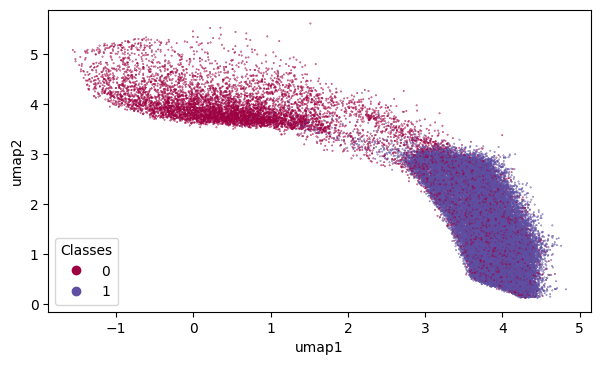

In [27]:
fig, ax = plt.subplots(1, figsize=(7,4), dpi=100,
                       subplot_kw={'xlabel': 'umap1', 
                                   'ylabel': 'umap2'})
scatter=plt.scatter(X_val_umap[:, 0], X_val_umap[:, 1],
            c=y_val, s=0.1, cmap='Spectral');
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")

In [99]:
# Create and fit selector
selector6 = SelectKBest(score_func=f_classif, k=6)
X_6 = selector6.fit_transform(transformed_X, y)
# Get columns to keep and create new dataframe with those only
cols6 = selector6.get_support(indices=True)
features_df_new6 = train.iloc[:,cols6]
features_df_new6.columns

/opt/conda/envs/python3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 67  73  76 101 113 119 122 128 131 136] are constant.
  UserWarning)
/opt/conda/envs/python3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Index(['p_R12', 'p_fTG3', 'p_Eratio', 'p_e255', 'p_e2ts1', 'p_wtots1'], dtype='object')

In [38]:
X_train6, X_val6, y_train6, y_val6 = train_test_split(X_6, y, test_size=0.25, 
                                                    shuffle=True, random_state=42)

In [60]:
X_train_umap6 = clusterable_embedding.fit_transform(X_train6)
#X_val_umap6 = clusterable_embedding.transform(X_val6)
X_test_umap6 = clusterable_embedding.transform(transformed_X_test_10)

UMAP(a=None, angular_rp_forest=False, b=None, dens_frac=0.0, dens_lambda=0.0,
     dens_var_shift=0.1, densmap=False, disconnection_distance=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=True, metric='euclidean',
     metric_kwds=None, min_dist=0.0, n_components=4, n_epochs=None, n_jobs=-1,
     n_neighbors=30, negative_sample_rate=5, output_dens=False,
     output_metric='euclidean', output_metric_kwds=None, random_state=42,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None, ...)
Construct fuzzy simplicial set
Mon May 24 10:55:44 2021 Finding Nearest Neighbors
Mon May 24 10:55:44 2021 Building RP forest with 22 trees
Mon May 24 10:55:45 2021 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	Stopping threshold met -- exiting after 2 iterations
Mon May 24 10:56:53 2021 Finished Nearest Neighbor Search
Mon May 24 10:56:56 2021 Construct em

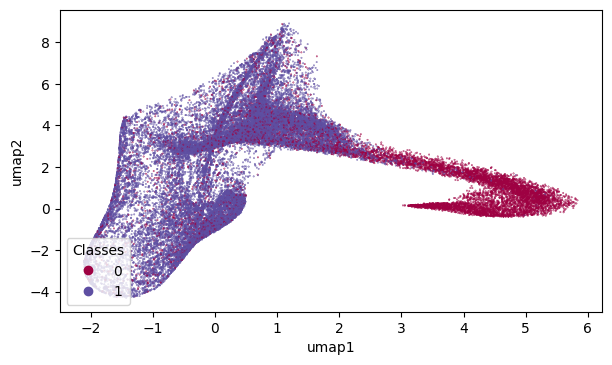

In [41]:
fig, ax = plt.subplots(1, figsize=(7,4), dpi=100,
                       subplot_kw={'xlabel': 'umap1', 
                                   'ylabel': 'umap2'})
scatter=plt.scatter(X_val_umap6[:, 0], X_val_umap6[:, 1],
            c=y_val, s=0.1, cmap='Spectral');
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")

### Gaussian mixture model

### clusterable embedding

In [49]:
gm_umap10 = GaussianMixture(n_components=4, random_state=0).fit(X_train_umap)
y_pred_umap10 = gm_umap10.predict(X_val_umap)

test_score_umap10 = accuracy_score(y_val, y_pred_umap10)
print(f"Test score: {test_score_umap:.3f}")

Test score: 0.080


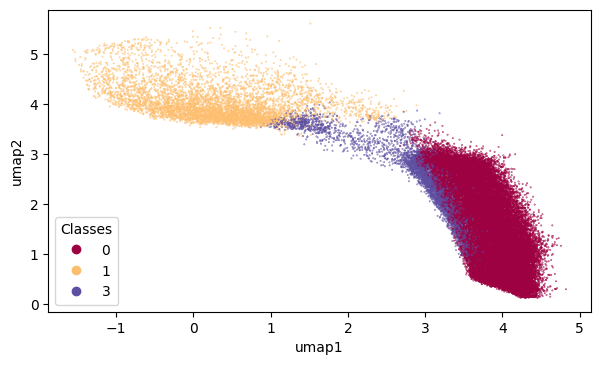

In [50]:
fig, ax = plt.subplots(1, figsize=(7,4), dpi=100,
                       subplot_kw={'xlabel': 'umap1', 
                                   'ylabel': 'umap2'})
scatter=plt.scatter(X_val_umap[:, 0], X_val_umap[:, 1],
            c=y_pred_umap10, s=0.1, cmap='Spectral');
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")

(array([31054.,     0.,     0.,  5533.,     0.,     0.,     0.,     0.,
            0.,  4038.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

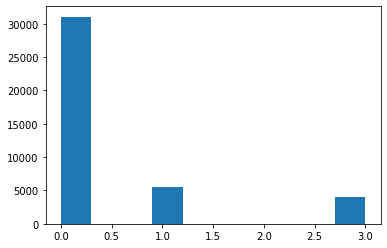

In [51]:
plt.hist(y_pred_umap10)

### raw data

In [168]:
gm_umap = GaussianMixture(n_components=4, random_state=0).fit(X_train)
y_pred = gm_umap.predict(X_val)

test_score = accuracy_score(y_val, y_pred)
print(f"Test score: {test_score:.3f}")

Test score: 0.275


(array([11890.,     0.,     0., 12861.,     0.,     0., 10960.,     0.,
            0.,  4914.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

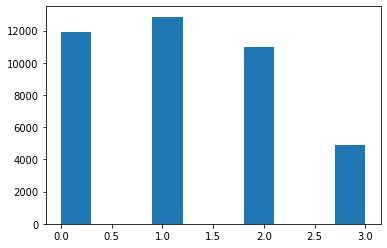

In [170]:
plt.hist(y_pred)

### Using 6 features

In [61]:
gm_umap6 = GaussianMixture(n_components=4, random_state=0).fit(X_train_umap6)
y_pred_umap6 = gm_umap6.predict(X_val_umap6)

test_score_umap6 = accuracy_score(y_val6, y_pred_umap6)
print(f"Test score: {test_score_umap6:.3f}")

Test score: 0.169


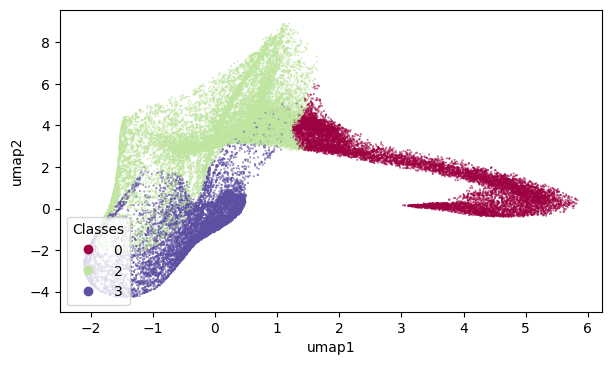

In [62]:
fig, ax = plt.subplots(1, figsize=(7,4), dpi=100,
                       subplot_kw={'xlabel': 'umap1', 
                                   'ylabel': 'umap2'})
scatter=plt.scatter(X_val_umap6[:, 0], X_val_umap6[:, 1],
            c=y_pred_umap6, s=0.1, cmap='Spectral');
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")

(array([ 9713.,     0.,     0.,     0.,     0.,     0., 20460.,     0.,
            0., 10452.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

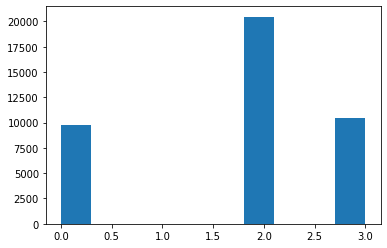

In [63]:
plt.hist(y_pred_umap6)

## Predict test data

In [56]:
# absClusterable embedding with umap and 10 features - Gaussian mixtures
test_umap_predictions_gm10 = gm_umap10.predict(X_test_umap)
out_df_10=pandas.DataFrame(test_umap_predictions_gm10)
out_df_10.to_csv('solutions/Clustering_NiallGray_GaussMix10feat.txt',header=False)


In [59]:
out_df_10.to_csv('solutions/Clustering_NiallGray_GaussMix10feat.txt',header=False)

In [64]:
# Clusterable embedding with umap and 6 features - Gaussian mixtures
test_umap_predictions_gm6 = gm_umap6.predict(X_test_umap6)
out_df_6=pandas.DataFrame(test_umap_predictions_gm6)
out_df_6.to_csv('solutions/Clustering_NiallGray_GaussMix6feat.txt',header=False)


In [90]:
# Clusterable embedding with umap, 10 features and Kmeans
test_umap_predictions_kmeans = kmeans.predict(X_test_umap6)
out_df_10=pandas.DataFrame(test_umap_predictions_kmeans)
out_df_10.to_csv('solutions/Clustering_NiallGray_KMeans6feat.txt',header=False)

In [72]:
out_df_10

,0
0,0
1,0
2,0
3,0
4,1
...,...
160646,0
160647,0
160648,3
160649,0


(array([116657.,      0.,      0.,  22917.,      0.,      0.,      0.,
             0.,      0.,  21077.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

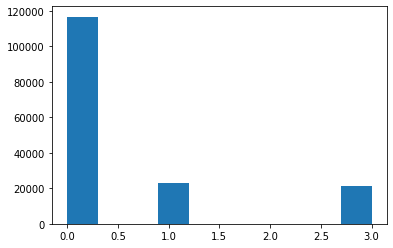

In [58]:
plt.hist(test_umap_predictions_gm10)

In [92]:
feature_list10=pandas.DataFrame(features_df_new.columns)

,0
0,p_R12
1,p_fTG3
2,p_Eratio
3,p_f1
4,p_ndof
5,p_e255
6,p_e2ts1
7,p_pos7
8,p_wtots1
9,p_E5x7_Lr2


In [95]:
feature_list10.to_csv('solutions/Clustering_NiallGray_GaussMix10feat_VariableList.txt',index=False, header=False)

In [100]:
feature_list6=pandas.DataFrame(features_df_new6.columns)

In [101]:
feature_list6

,0
0,p_R12
1,p_fTG3
2,p_Eratio
3,p_e255
4,p_e2ts1
5,p_wtots1


In [102]:
feature_list6.to_csv('solutions/Clustering_NiallGray_GaussMix6feat_VariableList.txt',index=False, header=False)

In [103]:
feature_list6.to_csv('solutions/Clustering_NiallGray_KMeans6feat_VariableList.txt',index=False, header=False)